In [49]:
import pandas as pd
import scrape as sc
import cleaning as cln
from datetime import date, datetime, time, timedelta

import scipy
import seaborn as sns

In [14]:
donors_file_loc = '/Users/mac/Documents/RU/THESIS/working_thesis/pilot_data_2/donors_appended/dikihermandagiziburuk_donorsinfo_appended.csv'
donation_file_loc = '/Users/mac/Documents/RU/THESIS/working_thesis/pilot_data_2/donation_prop.csv'
donors_save_loc = '/Users/mac/Documents/RU/THESIS/working_thesis/pilot_data_2/dikihermandagiziburuk_donorsinfo_cleaned.csv'
donation_loc = '/Users/mac/Documents/RU/THESIS/working_thesis/pilot_data_2/donation_prop_clean.csv'

df_donors = cln.clean_donors(donors_file_loc, donors_save_loc)
df_donations = cln.clean_donation(donation_file_loc, donation_loc)

           id  is_anonymous    amount  created_unix          created_ts  \
0  89346305.0          True   10000.0  1.663899e+09 2022-09-23 02:07:31   
1  89240706.0          True   10000.0  1.663812e+09 2022-09-22 01:59:59   
2  89197782.0          True   20000.0  1.663779e+09 2022-09-21 16:54:42   
3  89161421.0          True   10000.0  1.663726e+09 2022-09-21 01:59:22   
4  89098643.0          True  100000.0  1.663669e+09 2022-09-20 10:23:26   

         time_scrapped              short_url  
0  2022-09-23 19:16:58  dikihermandagiziburuk  
1  2022-09-23 19:16:58  dikihermandagiziburuk  
2  2022-09-23 19:16:58  dikihermandagiziburuk  
3  2022-09-23 19:16:58  dikihermandagiziburuk  
4  2022-09-23 19:16:58  dikihermandagiziburuk  
       id                            short_url  is_forever_runing  \
0  367402  bantusikecilarkanmelawanpenyakitnya              False   
1  371541              sapapeduliputrimaolidia              False   
2  378885                  bantudanaoperasidbs        

,Unnamed: 0,id,title,permalink,short_url,short_description,description,plain_description,image,youtube_video_id,...,parent_campaign.permalink,parent_campaign.is_verified,campaign_medical_detail.beneficiary_name,campaign_medical_detail.diagnosis,campaign_medical_detail.is_hospitalized,campaign_medical_detail.treatment,campaign_medical_detail.budget_allocation_plan,remaining_balance.total,remaining_balance.is_whitelist_campaign,time_scraped
6,0,371258,Yatim Alami Gizi Buruk dan Kejang 20 Kali Per ...,https://kitabisa.com/dikihermandagiziburuk,dikihermandagiziburuk,"Tanpa seorang Ayah, Diki Hermanda dilanda kebi...","<h4><br></h4><a href=""https://kitabisa.zendesk...",“Dulu badan Diki bisa gemetar dan kejang sampa...,https://img.kitabisa.cc/size/664x357/ee527112-...,NaN,...,NaN,False,Diki Hermanda,Polio & Gizi Buruk,0,Menunggu hasil pemeriksaan di RSUD Banten,"Biaya operasional Rp 30.000.000, biaya penunja...",0,False,2022-09-23 22:01:29


In [34]:
# 1. sort values by the earliest donors
df_donors.sort_values(by='created_ts', inplace=True)
df_donors.reset_index(drop=True, inplace=True)

# 2. calculate the cummulative sum of the donated amount
df_donors['cumsum_amt'] = df_donors['amount'].cumsum()

# 3. merge donation info with donors (only important column, without category variables)
df_donations = df_donations[df_donations['short_url'] == 'dikihermandagiziburuk']  # change this with the data set
col_to_merge_donation = ['short_url', 'donation_target', 'start_ts_utc']
df_donations_no_cat = df_donations[col_to_merge_donation]
df_merged_no_cat = pd.merge(df_donors, df_donations_no_cat, on='short_url')

# 4. calculate the percentage to the progress of every donation
df_merged_no_cat['percentage_progress'] = df_merged_no_cat['cumsum_amt'] / df_merged_no_cat['donation_target']

# 5. counting how many days have been passed since the donation starts
df_merged_no_cat['created_ts'] = pd.to_datetime(df_merged_no_cat['created_ts'], format='%Y-%m-%d %H:%M:%S')
df_merged_no_cat['start_ts_utc'] = pd.to_datetime(df_merged_no_cat['start_ts_utc'], format='%Y-%m-%d %H:%M:%S')
df_merged_no_cat['days_passed'] = df_merged_no_cat['created_ts'] - df_merged_no_cat['start_ts_utc']

# 7. converting created_ts to local timezone as it's converted from epoch, so it's still in UTC format
df_merged_no_cat['created_ts'] = pd.to_datetime(df_merged_no_cat['created_ts'], utc=True, format='%Y-%m-%d %H:%M:%S')
df_merged_no_cat['created_ts'] = df_merged_no_cat['created_ts'].dt.tz_convert('Etc/GMT+7')
df_merged_no_cat['day_ts'] = df_merged_no_cat['created_ts'].dt.day_name()

# 6. only taking important column and arrange it to make it easier to read
column_arrange = ['id', 'created_ts', 'day_ts', 'is_anonymous', 'amount', 'cumsum_amt', 
                  'percentage_progress', 'days_passed', 'short_url']
df_merged_no_cat = df_merged_no_cat[column_arrange]

df_merged_no_cat.head(5)

,id,created_ts,day_ts,is_anonymous,amount,cumsum_amt,percentage_progress,days_passed,short_url
0,80344492.0,2022-06-08 15:18:16-07:00,Wednesday,True,1000.0,1000.0,0.000005,0 days 11:43:20,dikihermandagiziburuk
1,80359472.0,2022-06-08 16:25:08-07:00,Wednesday,True,5000.0,6000.0,0.000032,0 days 12:50:12,dikihermandagiziburuk
2,80372073.0,2022-06-08 19:41:11-07:00,Wednesday,True,5000.0,11000.0,0.000058,0 days 16:06:15,dikihermandagiziburuk
3,80406944.0,2022-06-09 07:08:39-07:00,Thursday,False,10000.0,21000.0,0.000111,1 days 03:33:43,dikihermandagiziburuk
4,80408109.0,2022-06-09 07:23:30-07:00,Thursday,False,25000.0,46000.0,0.000243,1 days 03:48:34,dikihermandagiziburuk


In [36]:
# 7. merge category to data frame for seed donation and category analysis
col_to_merge_category = ['is_forever_runing', 'is_open_goal', 'is_zakat', 'is_instant_zakat', 'is_open_for_donation', 
                         'is_verified', 'is_optimized_by_ads', 'campaigner.is_verified', 'campaigner.type', 'category.name', 
                         'time_scraped', 'short_url']
df_donations_with_cat = df_donations[col_to_merge_category]

column_arrange_cat = ['id', 'created_ts', 'day_ts','is_anonymous', 'amount', 'cumsum_amt', 
                      'percentage_progress', 'days_passed', 'is_forever_runing', 'is_open_goal',
                      'is_zakat', 'is_instant_zakat', 'is_open_for_donation', 'is_verified', 
                      'is_optimized_by_ads', 'campaigner.is_verified', 'campaigner.type', 
                      'category.name', 'short_url', 'time_scraped']
df_merged_with_cat = pd.merge(df_merged_no_cat, df_donations_with_cat, on='short_url')
df_merged_with_cat = df_merged_with_cat[column_arrange_cat]

df_merged_with_cat.head(5)

,id,created_ts,day_ts,is_anonymous,amount,cumsum_amt,percentage_progress,days_passed,is_forever_runing,is_open_goal,is_zakat,is_instant_zakat,is_open_for_donation,is_verified,is_optimized_by_ads,campaigner.is_verified,campaigner.type,category.name,short_url,time_scraped
0,80344492.0,2022-06-08 15:18:16-07:00,Wednesday,True,1000.0,1000.0,0.000005,0 days 11:43:20,False,False,False,False,True,True,True,True,ORGANIZATION,Bantuan Medis & Kesehatan,dikihermandagiziburuk,2022-09-23 22:01:29
1,80359472.0,2022-06-08 16:25:08-07:00,Wednesday,True,5000.0,6000.0,0.000032,0 days 12:50:12,False,False,False,False,True,True,True,True,ORGANIZATION,Bantuan Medis & Kesehatan,dikihermandagiziburuk,2022-09-23 22:01:29
2,80372073.0,2022-06-08 19:41:11-07:00,Wednesday,True,5000.0,11000.0,0.000058,0 days 16:06:15,False,False,False,False,True,True,True,True,ORGANIZATION,Bantuan Medis & Kesehatan,dikihermandagiziburuk,2022-09-23 22:01:29
3,80406944.0,2022-06-09 07:08:39-07:00,Thursday,False,10000.0,21000.0,0.000111,1 days 03:33:43,False,False,False,False,True,True,True,True,ORGANIZATION,Bantuan Medis & Kesehatan,dikihermandagiziburuk,2022-09-23 22:01:29
4,80408109.0,2022-06-09 07:23:30-07:00,Thursday,False,25000.0,46000.0,0.000243,1 days 03:48:34,False,False,False,False,True,True,True,True,ORGANIZATION,Bantuan Medis & Kesehatan,dikihermandagiziburuk,2022-09-23 22:01:29


<AxesSubplot:xlabel='progress_bin', ylabel='count'>

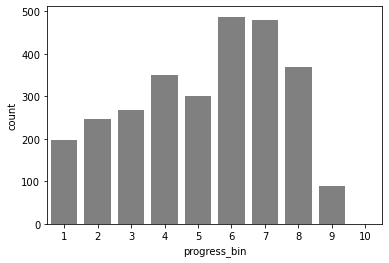

In [47]:
df_analysis = df_merged_with_cat

# bining the data by 10% incremental in the percentage progress
df_analysis['progress_bin'] = pd.cut(df_analysis["percentage_progress"],
                                     [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
                                     labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# count the value and plot it in histogram
df_analysis['progress_bin'].value_counts()
sns.countplot(x='progress_bin', data=df_analysis, color='gray')

In [48]:
from scipy.stats import f_oneway

df_analysis = df_analysis[df_analysis['percentage_progress'].between(0, 0.8)]  # automate this one
f_oneway(df_analysis)

2697